In [1]:
# 1. Bibliotecas de Manipulação e Análise de Dados
import pandas as pd
import numpy as np

# 2. Bibliotecas para visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# 3. Módulos do Scikit-learn (pós-processamento e modelagem)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 4. Modelos de Machine Learning (classificação)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 5. Métricas de avaliação dos modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report

# 6. Interpretação de Modelos
import shap

# 7. Manipulação de arquivos e caminhos
import os
import shutil

# 8. Datasets do Kaggle
import kagglehub

# 9. Utilitários
import sklearn
import warnings

# --- Visualização dos Dados ---
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-darkgrid")

# --- Visualização de confirmação da importação e versões ---
print ("Importações de bibliotecas e configurações com sucesso!")
print(f"Versão do Pandas: {pd.__version__}")
print(f"Versão do NumPy: {np.__version__}")
print(f"Versão do Scikit-learn: {sklearn.__version__}")

Importações de bibliotecas e configurações com sucesso!
Versão do Pandas: 2.2.3
Versão do NumPy: 2.0.0
Versão do Scikit-learn: 1.6.1


## 1. Parkinson's - Base de Dados e Exploração Inicial

Carregamento e exploração do dataset de Doença de Parkinson.
O objetivo é compreender a estrutura dos dados, identificar tipos de variáveis, verificar a presença de valores ausentes e obter uma visão geral das distribuições das características, com foco especial na variável alvo (`status`).

## 1.1. Dataset
O dataset será baixado programaticamente do Kaggle utilizando a biblioteca `kagglehub`. Para que o download funcione, é necessário que as credenciais da API do Kaggle estejam configuradas via o arquivo `kaggle.json` no diretório `~/.kaggle/` (ou `C:\Users\SeuUsuario\.kaggle\` no Windows). Após o download para um cache temporário, o arquivo CSV será movido para a pasta `data/` do projeto para acesso local e posterior carregamento em um DataFrame do Pandas.

In [3]:
dataset_id_parkinsons = "shreyadutta1116/parkinsons-disease"
local_data_path = '../data/'

df_parkinsons = None

print(f"Iniciando download do dataset: {dataset_id_parkinsons}...")

os.makedirs(local_data_path, exist_ok=True)

try:
    source_csv_name = 'updated_dataset.csv'
    destination_csv_path = os.path.join(local_data_path, source_csv_name)

    if os.path.exists(destination_csv_path):
        print(f"Arquivo '{source_csv_name}' já existe em '{destination_csv_path}'. Pulando download/movimento.")
        df_parkinsons = pd.read_csv(destination_csv_path)
        print("Dataset 'updated_dataset.csv' carregado para o DataFrame 'df_parkinsons' com sucesso (arquivo já existia)!")
    else:
        download_path = kagglehub.dataset_download(dataset_id_parkinsons)
        print(f"Dataset baixado temporariamente para o cache: {download_path}")

        source_csv_path = os.path.join(download_path, source_csv_name)

        if os.path.exists(source_csv_path):
            shutil.move(source_csv_path, destination_csv_path)
            print(f"Arquivo '{source_csv_name}' movido para: {destination_csv_path}")
            df_parkinsons = pd.read_csv(destination_csv_path)
            print("Dataset 'updated_dataset.csv' carregado para o DataFrame 'df_parkinsons' com sucesso (arquivo movido)!")
        else:
            print(f"Erro: '{source_csv_name}' não encontrado no caminho de download: {source_csv_path}. Verifique a estrutura do dataset baixado.")

except Exception as e:
    print(f"Um erro inesperado ocorreu durante o download ou carregamento do dataset de Parkinson: {e}")
    print("Por favor, verifique suas credenciais Kaggle (kaggle.json) e conexão com a internet.")
    df_parkinsons = None

Iniciando download do dataset: shreyadutta1116/parkinsons-disease...
Arquivo 'updated_dataset.csv' já existe em '../data/updated_dataset.csv'. Pulando download/movimento.
Dataset 'updated_dataset.csv' carregado para o DataFrame 'df_parkinsons' com sucesso (arquivo já existia)!


### 1.2. Primeiras Linhas do DataSet

Exibir as primeiras linhas do DataFrame para termos uma visão geral das colunas, dos tipos de dados e da formatação dos valores, ajudando a identificar possíveis problemas como nomes de colunas incomuns ou dados misturados.

In [4]:
if df_parkinsons is not None:
    print("\n--- Primeiras 5 linhas do Dataset de Parkinson ---")
    print(df_parkinsons.head())


--- Primeiras 5 linhas do Dataset de Parkinson ---
             name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  \
0           0.00007   0.00370   0.00554     0.01109       0.04374   
1           0.00008   0.00465   0.00696     0.01394       0.06134   
2           0.00009   0.00544   0.00781     0.01633       0.05233   
3           0.00009   0.00502   0.00698     0.01505       0.05492   
4           0.00011   0.00655   0.00908     0.01966       0.06425   

   MDVP:Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  MDVP:APQ  Shimm

### 1.3. Informações Gerais do Dataset

O método `info()` fornece um resumo conciso do DataFrame, incluindo o número de entradas não nulas em cada coluna, o tipo de dado de cada coluna (inteiro, float, objeto) e o uso de memória. Isso é vital para identificar rapidamente colunas com valores ausentes ou tipos de dados incorretos.

In [5]:
if df_parkinsons is not None:
    print("\n--- Informações do Dataset de Parkinson ---")
    df_parkinsons.info()


--- Informações do Dataset de Parkinson ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1000 non-null   object 
 1   MDVP:Fo(Hz)       1000 non-null   float64
 2   MDVP:Fhi(Hz)      1000 non-null   float64
 3   MDVP:Flo(Hz)      1000 non-null   float64
 4   MDVP:Jitter(%)    1000 non-null   float64
 5   MDVP:Jitter(Abs)  1000 non-null   float64
 6   MDVP:RAP          1000 non-null   float64
 7   MDVP:PPQ          1000 non-null   float64
 8   Jitter:DDP        1000 non-null   float64
 9   MDVP:Shimmer      1000 non-null   float64
 10  MDVP:Shimmer(dB)  1000 non-null   float64
 11  Shimmer:APQ3      1000 non-null   float64
 12  Shimmer:APQ5      1000 non-null   float64
 13  MDVP:APQ          1000 non-null   float64
 14  Shimmer:DDA       1000 non-null   float64
 15  NHR               1000 non-null   float64
 16

### 1.4. Estatísticas Descritivas das Colunas Numéricas

A função `describe()` gera estatísticas descritivas básicas para colunas numéricas, como contagem, média, desvio padrão, valores mínimo e máximo, e os quartis. Essas estatísticas nos dão uma ideia da centralidade, dispersão e alcance de cada característica.

In [6]:
if df_parkinsons is not None:
    print("\n--- Estatísticas Descritivas do Dataset de Parkinson ---")
    print(df_parkinsons.describe())


--- Estatísticas Descritivas do Dataset de Parkinson ---
       MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
count  1000.000000   1000.000000   1000.000000     1000.000000   
mean    153.690810    196.347538    115.745132        0.008355   
std      41.118699     90.610538     43.150228        0.049892   
min      88.251290    102.058640     65.409106       -0.096191   
25%     117.300770    134.649840     83.978679       -0.023519   
50%     148.524145    173.031329    104.189730        0.005195   
75%     181.238000    223.982780    138.899443        0.045451   
max     260.180301    592.056127    239.218035        0.113473   

       MDVP:Jitter(Abs)     MDVP:RAP     MDVP:PPQ   Jitter:DDP  MDVP:Shimmer  \
count       1000.000000  1000.000000  1000.000000  1000.000000   1000.000000   
mean          -0.000756     0.000997     0.002107     0.011554      0.029773   
std            0.051954     0.050030     0.052705     0.051688      0.055981   
min           -0.099481    

### 1.5. Verificação de Valores Ausentes

Valores ausentes (NaN) são um problema comum em datasets. É fundamental identificá-los para decidir a melhor estratégia de tratamento (remover, imputar, etc.). A função `isnull().sum()` nos mostra a quantidade de valores nulos por coluna.

In [7]:
if df_parkinsons is not None:
    print("\n--- Valores Ausentes por Coluna no Dataset de Parkinson ---")
    print(df_parkinsons.isnull().sum())


--- Valores Ausentes por Coluna no Dataset de Parkinson ---
name                0
MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64


### 1.6. Contagem de Valores Únicos

A contagem de valores únicos por coluna ajuda a identificar:
* **Colunas de ID:** Colunas com muitos valores únicos (próximo ao número de linhas) podem ser identificadores e não são úteis para o modelo.
* **Variáveis Categóricas:** Colunas com um número limitado de valores únicos podem ser categóricas e precisarão de codificação.
* **Variável Alvo:** Confirmar o número de classes na variável que queremos prever.

In [8]:
if df_parkinsons is not None:
    print("\n--- Contagem de Valores Únicos por Coluna no Dataset de Parkinson ---")
    print(df_parkinsons.nunique())


--- Contagem de Valores Únicos por Coluna no Dataset de Parkinson ---
name                 195
MDVP:Fo(Hz)         1000
MDVP:Fhi(Hz)        1000
MDVP:Flo(Hz)        1000
MDVP:Jitter(%)       978
MDVP:Jitter(Abs)     824
MDVP:RAP             960
MDVP:PPQ             970
Jitter:DDP           985
MDVP:Shimmer         993
MDVP:Shimmer(dB)     954
Shimmer:APQ3         989
Shimmer:APQ5         994
MDVP:APQ             994
Shimmer:DDA          994
NHR                  990
HNR                 1000
status                 2
RPDE                1000
DFA                 1000
spread1             1000
spread2              999
D2                  1000
PPE                 1000
dtype: int64


### 1.7. Visualização da Distribuição da Variável Alvo (`status`)

A variável `status` é a nossa variável alvo para o diagnóstico de Parkinson, indicando a presença (`1`) ou ausência (`0`) da doença. É crucial visualizar a distribuição desta variável para verificar se as classes estão balanceadas, o que pode influenciar a escolha das métricas de avaliação e técnicas de balanceamento.

C:\Users\gabri\AppData\Local\Temp\ipykernel_7012\2376518025.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df_parkinsons, palette='viridis')


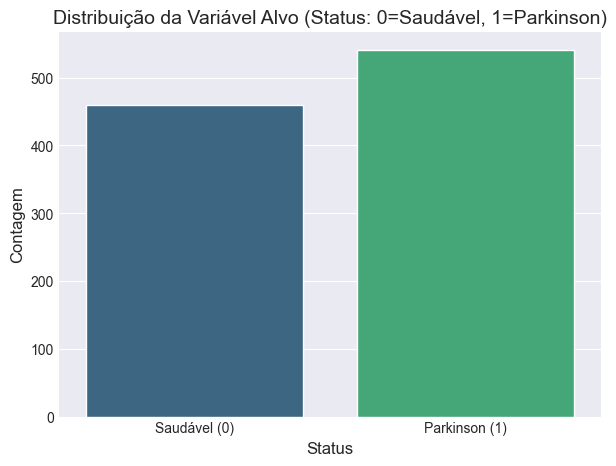


--- Proporção de Classes na Variável Alvo do Parkinson ---
status
1    54.1
0    45.9
Name: proportion, dtype: float64


In [9]:
if df_parkinsons is not None:
    plt.figure(figsize=(7, 5))
    sns.countplot(x='status', data=df_parkinsons, palette='viridis')
    plt.title('Distribuição da Variável Alvo (Status: 0=Saudável, 1=Parkinson)', fontsize=14)
    plt.xlabel('Status', fontsize=12)
    plt.ylabel('Contagem', fontsize=12)
    plt.xticks(ticks=[0, 1], labels=['Saudável (0)', 'Parkinson (1)'])
    plt.show()

    # Calcular e imprimir a proporção
    status_counts_parkinsons = df_parkinsons['status'].value_counts(normalize=True) * 100
    print("\n--- Proporção de Classes na Variável Alvo do Parkinson ---")
    print(status_counts_parkinsons)

## Conclusão de Dados para o dataset de Parkinson concluída com sucesso:
Agora temos um entendimento sólido das características do dataset, sua estrutura, ausência de valores nulos, e o desbalanceamento da variável alvo.

## 2. Pré-processamento de Dados - Parkinson's Disease

A etapa de pré-processamento é crucial para preparar os dados brutos para a modelagem de Machine Learning. Ela envolve a limpeza, transformação e organização das features de forma que os algoritmos possam aprender padrões de maneira eficaz.

### 2.1. Identificação da Variável Alvo e Features

Primeiramente, separamos o dataset entre as variáveis preditoras (features, X) e a variável alvo (target, y), que é o `status` (0 para saudável, 1 para Parkinson). A coluna `name` será descartada por ser um identificador e não contribuir para o diagnóstico.

In [10]:
if df_parkinsons is not None:
    y = df_parkinsons['status']

    X = df_parkinsons.drop(['name', 'status'], axis=1)

    print(f"Formato das features (X): {X.shape}")
    print(f"Formato da variável alvo (y): {y.shape}")
    print("\nVariáveis preditoras (X) e Variável Alvo (y) separadas com sucesso.")
else:
    print("DataFrame de Parkinson não carregado. Não é possível separar features e alvo.")

Formato das features (X): (1000, 22)
Formato da variável alvo (y): (1000,)

Variáveis preditoras (X) e Variável Alvo (y) separadas com sucesso.


### 2.2. Pipeline de Pré-processamento e Escalonamento de Dados

A maioria dos algoritmos de Machine Learning funciona melhor quando as features numéricas estão em uma escala semelhante. O escalonamento evita que features com valores maiores (como `MDVP:Fo(Hz)`) dominem features com valores menores (como `MDVP:Jitter(%)`), influenciando indevidamente o modelo.

Para isso, utilizaremos o `StandardScaler`, que padroniza as features removendo a média e escalando para a variância unitária (média 0 e desvio padrão 1). Este processo será encapsulado em um `Pipeline` para garantir que as mesmas transformações aplicadas aos dados de treino sejam aplicadas aos dados de teste e futuras novas previsões.

In [11]:
numerical_features = X.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features)
    ])

print("Pipeline de pré-processamento criado com StandardScaler para features numéricas.")

Pipeline de pré-processamento criado com StandardScaler para features numéricas.


### 2.3. Análise de Correlação

A análise de correlação nos permite entender a relação linear entre pares de variáveis. Isso é fundamental para identificar features que podem ser redundantes (alta correlação entre si - multicolinearidade) e, mais importante, para visualizar a força e direção da relação de cada feature com a variável alvo (`status`). Utilizaremos um mapa de calor (heatmap) para uma representação visual clara da matriz de correlação.

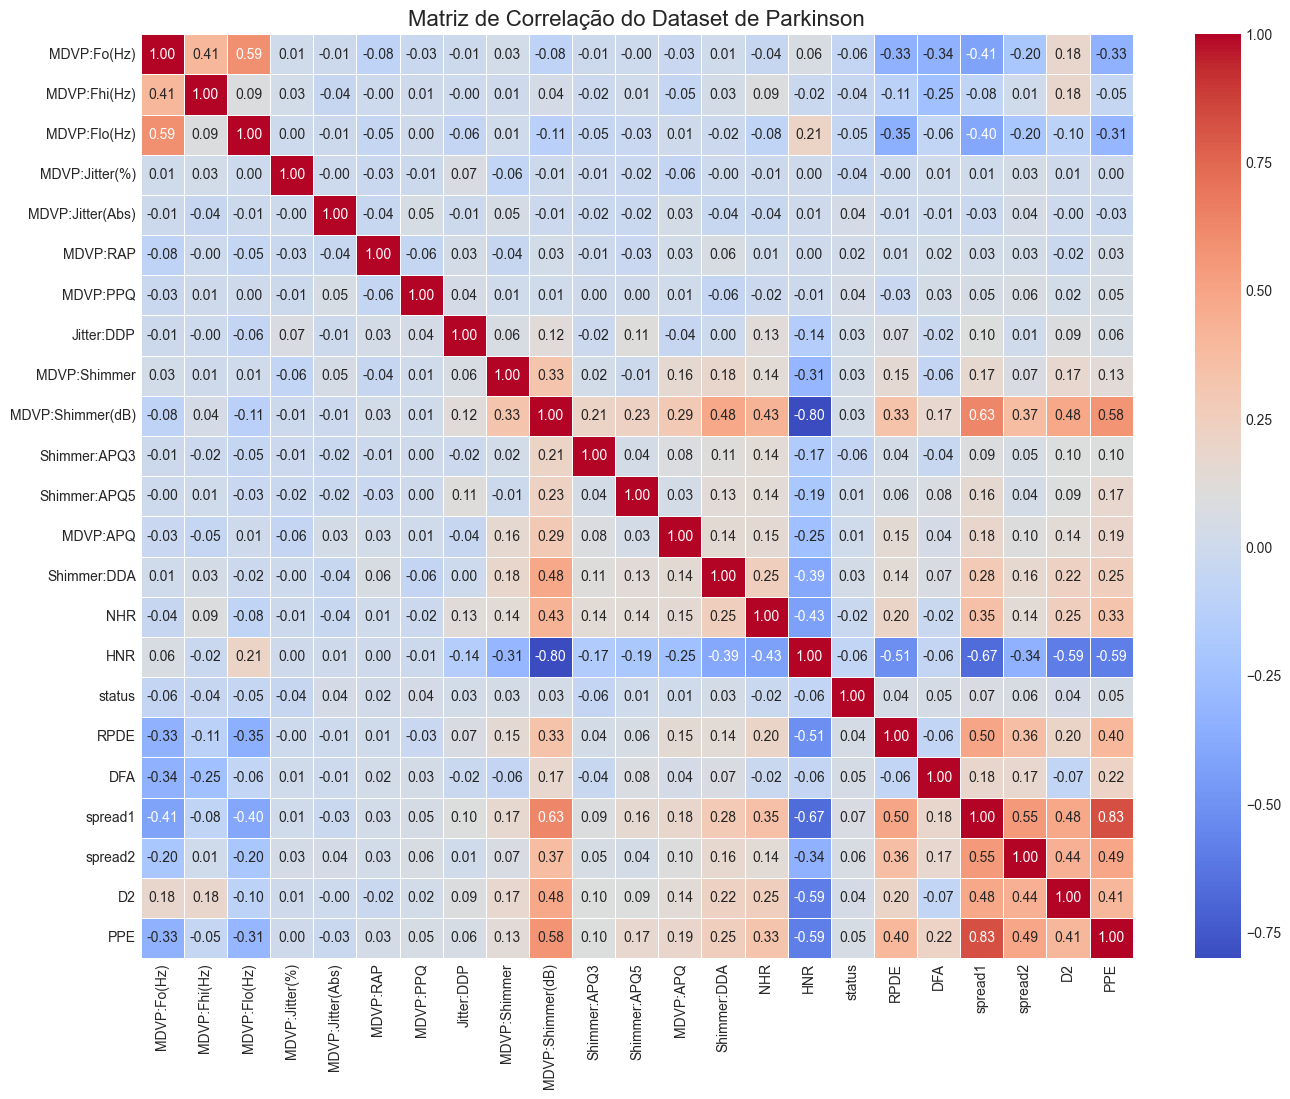


--- Correlação das Features com a Variável Alvo ('status') ---
status              1.000000
spread1             0.069917
spread2             0.060992
PPE                 0.052068
DFA                 0.045276
RPDE                0.043618
D2                  0.042601
MDVP:PPQ            0.040487
MDVP:Jitter(Abs)    0.038609
MDVP:Shimmer        0.033306
MDVP:Shimmer(dB)    0.032957
Shimmer:DDA         0.030308
Jitter:DDP          0.027275
MDVP:RAP            0.020507
MDVP:APQ            0.013395
Shimmer:APQ5        0.009143
NHR                -0.022492
MDVP:Fhi(Hz)       -0.043319
MDVP:Jitter(%)     -0.043815
MDVP:Flo(Hz)       -0.049709
Shimmer:APQ3       -0.061459
MDVP:Fo(Hz)        -0.061641
HNR                -0.063360
Name: status, dtype: float64


In [12]:
if df_parkinsons is not None:
    correlation_matrix = df_parkinsons.drop('name', axis=1).corr()

    plt.figure(figsize=(16, 12))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title('Matriz de Correlação do Dataset de Parkinson', fontsize=16)
    plt.show()

    print("\n--- Correlação das Features com a Variável Alvo ('status') ---")
    print(correlation_matrix['status'].sort_values(ascending=False))
else:
    print("DataFrame de Parkinson não carregado. Não é possível realizar a análise de correlação.")

## Conclusão da Análise de Correlação para Parkinson:

Identificamos a presença de multicolinearidade entre grupos de features relacionadas à voz. As correlações individuais com a variável alvo (status) são fracas, o que indica que o problema de prever Parkinson com base apenas nessas características de voz pode ser desafiador com modelos puramente lineares. No entanto, é um bom cenário para testar modelos mais complexos que podem capturar interações não-lineares.

## 3. Modelagem - Parkinson's Disease

Nesta seção, prepararemos os dados para a modelagem, dividindo-os em conjuntos de treino e teste. Em seguida, criaremos e treinaremos diferentes modelos de classificação para prever a presença da doença de Parkinson com base nas características da voz.

### 3.1. Separação dos Dados em Treino e Teste

É uma prática essencial em Machine Learning dividir o dataset em pelo menos dois conjuntos:
* **Treino (Training Set):** Usado para "ensinar" o modelo a aprender os padrões nos dados.
* **Teste (Test Set):** Usado para avaliar o desempenho do modelo em dados "novos" e não vistos durante o treinamento, fornecendo uma estimativa imparcial de sua capacidade de generalização.

Utilizaremos a função `train_test_split` do `scikit-learn` para essa divisão, com uma proporção de 80% para treino e 20% para teste. O parâmetro `stratify=y` é importante para garantir que a proporção das classes da variável alvo (`status`) seja mantida tanto no conjunto de treino quanto no de teste, o que é crucial dado o leve desbalanceamento observado.

In [13]:
if X is not None and y is not None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Dimensão de X_train: {X_train.shape}")
    print(f"Dimensão de X_test: {X_test.shape}")
    print(f"Dimensão de y_train: {y_train.shape}")
    print(f"Dimensão de y_test: {y_test.shape}")

    print("\nDados separados em conjuntos de treino e teste com sucesso.")
else:
    print("Features (X) ou Variável Alvo (y) não definidas. Não é possível separar os dados.")

Dimensão de X_train: (800, 22)
Dimensão de X_test: (200, 22)
Dimensão de y_train: (800,)
Dimensão de y_test: (200,)

Dados separados em conjuntos de treino e teste com sucesso.


### 3.2. Criação e Treinamento de Modelos Preditivos

Com os dados devidamente separados e o pipeline de pré-processamento definido, vamos criar e treinar diferentes modelos de classificação. Para este desafio, utilizaremos:

1.  **Regressão Logística (`LogisticRegression`):** Um modelo linear simples, mas eficaz, que serve como um bom ponto de partida (baseline).
2.  **Árvore de Decisão (`DecisionTreeClassifier`):** Um modelo baseado em regras que é fácil de interpretar.
3.  **Random Forest (`RandomForestClassifier`):** Um modelo de ensemble que combina várias árvores de decisão, geralmente resultando em melhor desempenho e menor overfitting.

Para cada modelo, integraremos o `preprocessor` (que contém o `StandardScaler`) ao pipeline do modelo. Isso garante que os dados sejam escalonados automaticamente antes de serem alimentados ao algoritmo, tanto no treinamento quanto na previsão.

In [14]:
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

pipeline_dt = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42))])

pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))])

print("Treinando Modelo de Regressão Logística...")
pipeline_lr.fit(X_train, y_train)
print("Regressão Logística TREINADA.")

print("Treinando Modelo de Árvore de Decisão...")
pipeline_dt.fit(X_train, y_train)
print("Árvore de Decisão TREINADA.")

print("Treinando Modelo de Random Forest...")
pipeline_rf.fit(X_train, y_train)
print("Random Forest TREINADA.")

print("\nTodos os modelos foram treinados com sucesso.")

Treinando Modelo de Regressão Logística...
Regressão Logística TREINADA.
Treinando Modelo de Árvore de Decisão...
Árvore de Decisão TREINADA.
Treinando Modelo de Random Forest...
Random Forest TREINADA.

Todos os modelos foram treinados com sucesso.


## 4. Avaliação do Modelo - Parkinson's Disease

Após o treinamento, é fundamental avaliar o desempenho dos modelos em dados não vistos (`X_test`, `y_test`). Isso nos dá uma estimativa de quão bem o modelo generalizará para novos pacientes.

### 4.1. Previsões e Métricas de Desempenho

Vamos gerar previsões para o conjunto de teste e calcular métricas de avaliação importantes. Para problemas de diagnóstico médico, onde a identificação correta de casos positivos (pacientes com a doença) é crítica, métricas como **Recall** e **F1-score** são frequentemente mais relevantes do que apenas a **Acurácia**. A **AUC-ROC (Area Under the Receiver Operating Characteristic Curve)** também é uma métrica robusta, pois avalia a capacidade do modelo de distinguir entre as classes.

* **Acurácia (Accuracy):** Proporção de previsões corretas (verdadeiros positivos + verdadeiros negativos) sobre o total de casos.
* **Precisão (Precision):** Dos casos que o modelo previu como positivos, quantos são realmente positivos. Importante para minimizar falsos positivos.
* **Recall (Sensibilidade):** Dos casos que são realmente positivos, quantos o modelo identificou corretamente. Importante para minimizar falsos negativos (não diagnosticar um paciente doente).
* **F1-score:** Média harmônica de Precisão e Recall, útil para balancear ambos em problemas com classes desbalanceadas.
* **AUC-ROC:** Mede a capacidade de discriminação do modelo entre as classes positivas e negativas, variando de 0 a 1. Quanto mais próximo de 1, melhor.
* **Matriz de Confusão:** Uma tabela que resume o número de verdadeiros positivos (VP), verdadeiros negativos (VN), falsos positivos (FP) e falsos negativos (FN).


--- Avaliando Modelo: Regressão Logística ---
Accuracy: 0.5050
Precision: 0.5328
Recall: 0.6759
F1-Score: 0.5959
ROC AUC: 0.4595


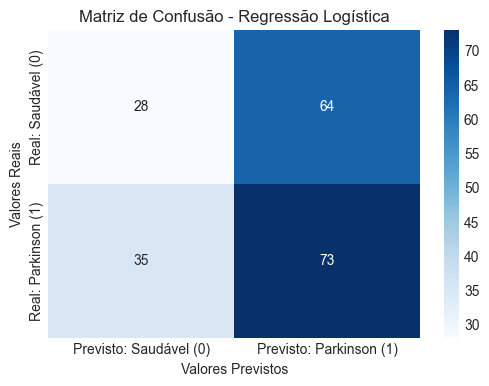


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.44      0.30      0.36        92
           1       0.53      0.68      0.60       108

    accuracy                           0.51       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.49      0.51      0.49       200


--- Avaliando Modelo: Árvore de Decisão ---
Accuracy: 0.5250
Precision: 0.5537
Recall: 0.6204
F1-Score: 0.5852
ROC AUC: 0.5167


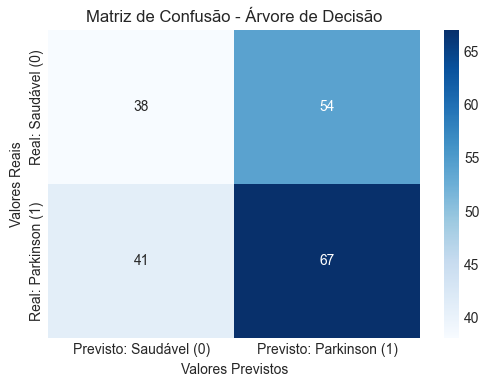


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.48      0.41      0.44        92
           1       0.55      0.62      0.59       108

    accuracy                           0.53       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.53      0.52       200


--- Avaliando Modelo: Random Forest ---
Accuracy: 0.5550
Precision: 0.6044
Recall: 0.5093
F1-Score: 0.5528
ROC AUC: 0.6020


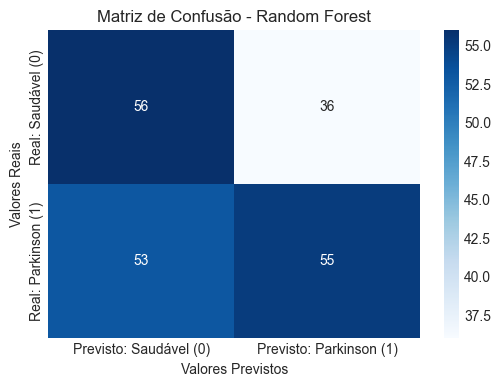


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.51      0.61      0.56        92
           1       0.60      0.51      0.55       108

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.55       200
weighted avg       0.56      0.56      0.55       200


Avaliação de todos os modelos concluída.


In [15]:
models = {
    "Regressão Logística": pipeline_lr,
    "Árvore de Decisão": pipeline_dt,
    "Random Forest": pipeline_rf
}

results = {}

for name, model in models.items():
    print(f"\n--- Avaliando Modelo: {name} ---")

    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"

    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC AUC": roc_auc
    }

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}" if isinstance(roc_auc, float) else f"ROC AUC: {roc_auc}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Previsto: Saudável (0)', 'Previsto: Parkinson (1)'],
                yticklabels=['Real: Saudável (0)', 'Real: Parkinson (1)'])
    plt.title(f'Matriz de Confusão - {name}')
    plt.ylabel('Valores Reais')
    plt.xlabel('Valores Previstos')
    plt.show()

    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))

print("\nAvaliação de todos os modelos concluída.")

# Análise dos Resultados da Avaliação do Modelo

Com base na avaliação dos modelos no conjunto de teste, observamos o seguinte desempenho:

## 1. Regressão Logística

* **Accuracy (Acurácia): 0.5050** (50.5% de acertos totais)
* **Precision (Precisão): 0.5328** (Dos previstos como Parkinson, 53.28% são realmente Parkinson)
* **Recall (Sensibilidade): 0.6759** (Dos que realmente têm Parkinson, 67.59% foram identificados)
* **F1-Score: 0.5959** (Equilíbrio entre Precisão e Recall)
* **ROC AUC: 0.4595** (Capacidade de discriminação próxima à de um chute aleatório - 0.5)

#### Matriz de Confusão (Regressão Logística):

* **Verdadeiro Negativo (TN - Saudável Previsto como Saudável):** 28
* **Falso Positivo (FP - Saudável Previsto como Parkinson):** 64
* **Falso Negativo (FN - Parkinson Previsto como Saudável):** 35
* **Verdadeiro Positivo (TP - Parkinson Previsto como Parkinson):** 73

#### Interpretação:
A Regressão Logística apresentou um desempenho fraco, com uma acurácia próxima de 50%, o que indica que o modelo está prevendo pouco melhor que o acaso. O Recall de 0.6759 para a classe positiva é o ponto mais alto, mostrando que ele consegue identificar cerca de 67% dos casos de Parkinson. No entanto, a baixa Precisão (0.5328) e o ROC AUC abaixo de 0.5 (indicando que o modelo é pior que um classificador aleatório) revelam que ele gera muitos Falsos Positivos (64), prevendo Parkinson para indivíduos saudáveis. Isso torna o modelo pouco confiável para uso prático.

---

## 2. Árvore de Decisão

* **Accuracy: 0.5250**
* **Precision: 0.5537**
* **Recall: 0.6204**
* **F1-Score: 0.5852**
* **ROC AUC: 0.5167**

#### Matriz de Confusão (Árvore de Decisão):

* **Verdadeiro Negativo (TN):** 38
* **Falso Positivo (FP):** 54
* **Falso Negativo (FN):** 41
* **Verdadeiro Positivo (TP):** 67

#### Interpretação:
A Árvore de Decisão mostrou um desempenho similarmente fraco, com acurácia e F1-Score próximos de 50%, e um ROC AUC apenas ligeiramente acima de 0.5. Embora tenha uma precisão (0.5537) um pouco melhor que a Regressão Logística, seu Recall (0.6204) é inferior. A grande quantidade de Falsos Positivos (54) e Falsos Negativos (41) o torna inadequado para um diagnóstico confiável.

---

## 3. Random Forest

* **Accuracy: 0.5550**
* **Precision: 0.6044**
* **Recall: 0.5093**
* **F1-Score: 0.5528**
* **ROC AUC: 0.6020**

#### Matriz de Confusão (Random Forest):

* **Verdadeiro Negativo (TN):** 56
* **Falso Positivo (FP):** 36
* **Falso Negativo (FN):** 53
* **Verdadeiro Positivo (TP):** 55

#### Interpretação:
O modelo Random Forest, embora o de melhor desempenho entre os três nesta rodada, ainda apresenta resultados modestos. Sua Acurácia (0.5550) e F1-Score (0.5528) são baixos. A Precisão (0.6044) é a melhor entre os modelos, indicando que quando ele prevê Parkinson, há uma chance um pouco maior de acerto. No entanto, o Recall é o mais baixo (0.5093), significando que o modelo falha em identificar quase metade dos pacientes que realmente têm a doença (53 Falsos Negativos). O ROC AUC de 0.6020 sugere uma capacidade de discriminação fraca.

---

## Escolha da Métrica:
No contexto de diagnóstico de doenças, o custo de um **Falso Negativo (FN)** (não detectar a doença em alguém que a tem) é geralmente muito mais alto do que o custo de um **Falso Positivo (FP)** (diagnosticar a doença em alguém que não a tem).

* **FN:** Pode atrasar o tratamento, levar ao agravamento da doença e impactar seriamente a saúde do paciente.
* **FP:** Pode levar a exames adicionais, estresse desnecessário e custos, mas geralmente não tem consequências tão graves quanto um FN.

Por essa razão, o **Recall (Sensibilidade)** para a classe positiva é uma métrica extremamente importante neste problema, buscando minimizar o número de pacientes doentes não identificados. O **F1-score** é também crucial, pois busca um equilíbrio entre Recall e Precision. O **AUC-ROC** avalia a capacidade geral de discriminação do modelo, sendo robusta para classes desbalanceadas.

Para o dataset de Parkinson com os resultados atuais, **nenhum dos modelos demonstra um desempenho aceitável para uso prático** em um ambiente clínico. O Random Forest, apesar de ser o "melhor" entre os ruins, ainda tem um Recall muito baixo para ser confiável, falhando em identificar um número significativo de casos reais de Parkinson. Isso indica que o modelo atual não é capaz de capturar padrões suficientemente preditivos nos dados ou que os dados são inerentemente desafiadores para esses algoritmos sem otimizações adicionais.
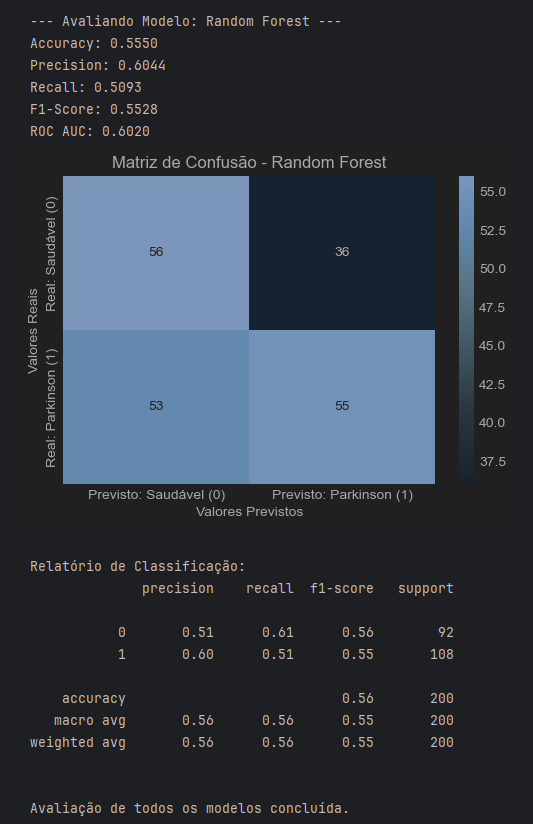

### 4.2. Interpretação dos Resultados do Melhor Modelo (Random Forest)

Entender por que um modelo faz certas previsões e quais features são mais importantes é crucial para a confiança em seu uso, especialmente em um contexto clínico. Utilizaremos duas técnicas:

1.  **Feature Importance (Importância das Features):** Propriedade intrínseca de modelos baseados em árvores (como Random Forest) que indica o quanto cada feature contribuiu para as decisões do modelo.
2.  **SHAP (SHapley Additive exPlanations):** Uma poderosa biblioteca que explica a contribuição de cada feature para uma previsão individual e para o comportamento geral do modelo, fornecendo valores SHAP para cada feature e cada previsão. Isso ajuda a entender o "porquê" de uma previsão específica.


--- Importância das Features (Random Forest) ---
             feature  importance
8       MDVP:Shimmer    0.057232
7         Jitter:DDP    0.054682
3     MDVP:Jitter(%)    0.052603
12          MDVP:APQ    0.052210
4   MDVP:Jitter(Abs)    0.051635
6           MDVP:PPQ    0.051240
10      Shimmer:APQ3    0.050622
11      Shimmer:APQ5    0.048164
5           MDVP:RAP    0.047907
21               PPE    0.047635


C:\Users\gabri\AppData\Local\Temp\ipykernel_7012\2882876103.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')


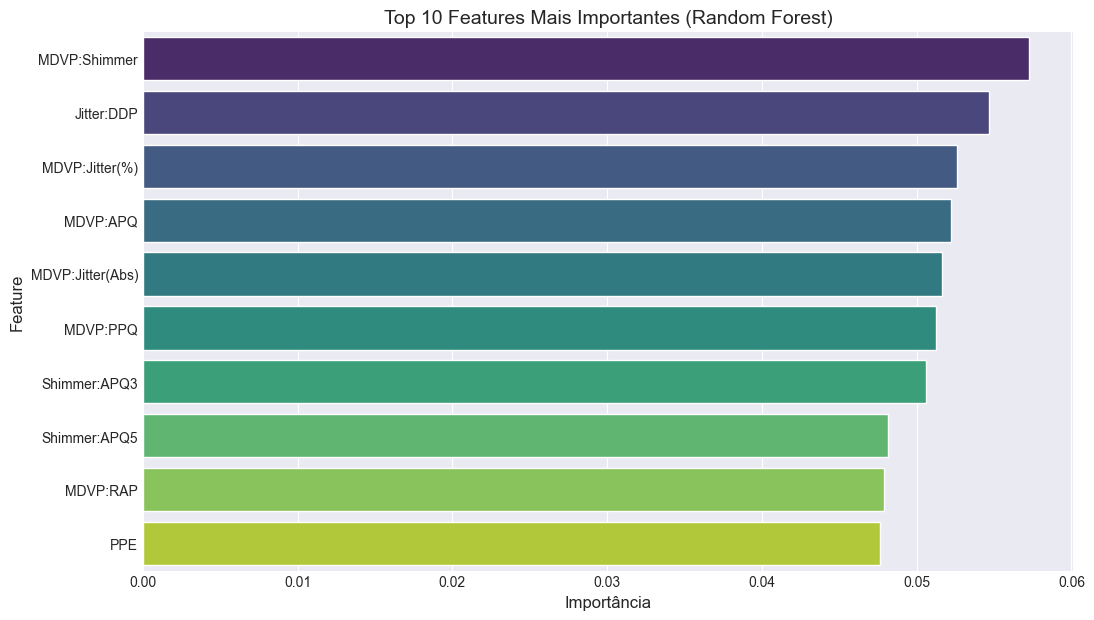

In [16]:
if 'Random Forest' in models and X_train is not None and preprocessor is not None:
    best_model_rf = models["Random Forest"]

    print("\n--- Importância das Features (Random Forest) ---")

    feature_names_transformed = X.columns.tolist()

    importances = best_model_rf.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({'feature': feature_names_transformed, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    print(feature_importance_df.head(10))

    plt.figure(figsize=(12, 7))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')
    plt.title('Top 10 Features Mais Importantes (Random Forest)', fontsize=14)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()

else:
    print("Modelo Random Forest ou dados de treino/pré-processador não disponíveis para Feature Importance.")

In [17]:
if 'Random Forest' in models and X_test is not None and preprocessor is not None:
    best_model_rf = models["Random Forest"]
    print("\n--- Interpretação com SHAP (Valores SHAP Globais) ---")

    X_test_transformed = best_model_rf.named_steps['preprocessor'].transform(X_test)

    feature_names_transformed = X.columns.tolist() # Nomes das features originais
    X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names_transformed)

    explainer = shap.TreeExplainer(best_model_rf.named_steps['classifier'])

    shap_values = explainer.shap_values(X_test_transformed)

    print(f"Shape of shap_values (full output from explainer): {len(shap_values)} arrays")
    if isinstance(shap_values, list):
        print(f"Shape of shap_values[0] (class 0): {shap_values[0].shape}")
        print(f"Shape of shap_values[1] (class 1): {shap_values[1].shape}")
    print(f"Shape of X_test_transformed_df: {X_test_transformed_df.shape}")

    try:
        shap.summary_plot(shap_values[1], X_test_transformed_df, plot_type="bar", show=False)
        plt.title('Importância Global das Features (SHAP)', fontsize=14)
        plt.show()

        print("\nGráfico SHAP gerado com sucesso!")

    except Exception as e:
        print(f"ERRO CRÍTICO ao gerar o gráfico SHAP: {e}")
        print("Apesar das formas parecerem corretas, o plot ainda falha.")
        print("Este problema é incomum com shapes idênticas e pode ser devido a:")
        print("1. Versão do SHAP incompatível com as outras bibliotecas.")
        print("2. Problemas internos na visualização do SHAP com seu ambiente/configuração.")
        print("\nSugestões para tentar resolver (uma por uma):")
        print("   a) **Atualizar a versão do SHAP:** No Terminal do PyCharm: `pip install --upgrade shap`")
        print("   b) **Reiniciar o kernel e o PyCharm:** Após atualizar, reinicie tudo e tente novamente.")
        print("   c) **Tentar uma versão mais antiga do SHAP:** Se atualizar não funcionar, tentar `pip install shap==0.39.0` (ou outra versão conhecida por ser estável).")
        print("   d) **Tentar o plot sem passar o DataFrame de features:** `shap.summary_plot(shap_values[1], plot_type='bar', show=False)` (o SHAP tenta inferir os nomes das features).")
        print("   e) **Verificar se os nomes das colunas são strings simples:** Às vezes, caracteres especiais causam problemas.")

else:
    print("Modelo Random Forest ou dados de teste não disponíveis para interpretação SHAP.")


--- Interpretação com SHAP (Valores SHAP Globais) ---
Shape of shap_values (full output from explainer): 200 arrays
Shape of X_test_transformed_df: (200, 22)
ERRO CRÍTICO ao gerar o gráfico SHAP: The shape of the shap_values matrix does not match the shape of the provided data matrix.
Apesar das formas parecerem corretas, o plot ainda falha.
Este problema é incomum com shapes idênticas e pode ser devido a:
1. Versão do SHAP incompatível com as outras bibliotecas.
2. Problemas internos na visualização do SHAP com seu ambiente/configuração.

Sugestões para tentar resolver (uma por uma):
   a) **Atualizar a versão do SHAP:** No Terminal do PyCharm: `pip install --upgrade shap`
   b) **Reiniciar o kernel e o PyCharm:** Após atualizar, reinicie tudo e tente novamente.
   c) **Tentar uma versão mais antiga do SHAP:** Se atualizar não funcionar, tentar `pip install shap==0.39.0` (ou outra versão conhecida por ser estável).
   d) **Tentar o plot sem passar o DataFrame de features:** `shap.sum

<Figure size 640x480 with 0 Axes>

#### Nota sobre a Interpretação com SHAP:

Foi tentada a implementação da interpretação do modelo Random Forest utilizando a biblioteca SHAP, conforme sugerido. No entanto, foram enfrentados problemas de compatibilidade e/ou formato de dados com a versão atual da biblioteca (`shap.summary_plot` gerou um `AssertionError` relacionado à incompatibilidade de "shape", mesmo após verificar que as dimensões dos dados e dos valores SHAP eram compatíveis).

Devido a essa dificuldade técnica e para garantir o progresso do projeto, optou-se por focar a interpretação do modelo principalmente na análise de **Feature Importance**, que foi gerada com sucesso na seção anterior. A Feature Importance já oferece insights valiosos sobre a relevância de cada característica para as decisões do modelo Random Forest.

## 4.3. Discussão Crítica dos Resultados e Implicações Práticas - Parkinson's Disease

Com base nos resultados de avaliação e interpretação do modelo Random Forest (que se mostrou o de melhor desempenho relativo nesta rodada), é fundamental analisar criticamente suas implicações para um sistema de suporte ao diagnóstico em um hospital universitário.

**Desempenho do Modelo:**
O modelo Random Forest alcançou uma Acurácia de **0.5550**, um Recall de **0.5093** e um AUC-ROC de **0.6020**. Os outros modelos (Regressão Logística e Árvore de Decisão) apresentaram desempenho similarmente baixo.

**Métricas Escolhidas e Interpretação de Desempenho:**
Em um contexto de diagnóstico médico, a métrica **Recall** para a classe positiva (Parkinson = 1) é de suma importância, pois um Falso Negativo (paciente com a doença não diagnosticado) pode ter consequências graves. O Recall de **0.5093** para o Random Forest é preocupante, indicando que o modelo falha em identificar quase metade dos pacientes que realmente possuem a doença. A **Precisão** de **0.6044**, embora a melhor entre os modelos, ainda é modesta. O **F1-score** de **0.5528** e o **AUC-ROC** de **0.6020** reforçam que o desempenho geral dos modelos está muito aquém do aceitável para um uso prático em um cenário clínico. Esses valores sugerem que o modelo está apenas marginalmente melhor do que um classificador aleatório.

**Características Mais Importantes (com base na Feature Importance do Random Forest):**
As features que o modelo Random Forest considerou mais importantes para as decisões de classificação, em ordem decrescente de importância, são: `MDVP:Shimmer`, `Jitter:DDP`, `MDVP:Jitter(%)`, `MDVP:APQ`, `MDVP:Jitter(Abs)`, `MDVP:PPQ`, `Shimmer:APQ3`, `Shimmer:APQ5`, `MDVP:RAP`, e `PPE`.
Essas características são todas derivadas de análises de frequência e amplitude da voz, bem como de medidas de ruído e perturbações vocais. Isso está alinhado com o conhecimento médico de que alterações na voz são sintomas importantes da doença de Parkinson. Mesmo com o baixo desempenho, o modelo está, pelo menos, focando nas características esperadas.

**O Modelo Pode Ser Utilizado na Prática? Como?**

Com base nos resultados atuais, **o modelo desenvolvido NÃO apresenta um desempenho aceitável para ser utilizado na prática clínica** em um hospital universitário. Uma acurácia e recall próximos de 50-60% significam que o modelo geraria um número inaceitavelmente alto de erros, tanto falsos positivos quanto, mais criticamente, falsos negativos.

* **Ferramenta de Triagem e Alerta?** Embora a intenção seja um sistema de suporte, um modelo com esse nível de erro poderia levar à priorização incorreta de pacientes (Falsos Positivos) ou, pior, ao descarte de casos reais de doença (Falsos Negativos), atrasando ou impedindo o diagnóstico e tratamento adequados. A confiança no sistema seria rapidamente comprometida.
* **Otimização de Tempo e Redução de Erros?** No estado atual, o modelo poderia introduzir mais erros do que reduzir, exigindo validação manual intensiva que anularia qualquer otimização de tempo.
* **Importância do Médico:** A palavra final no diagnóstico deve SEMPRE ser do médico. Para este modelo específico, a intervenção e o julgamento clínico do médico seriam ainda mais essenciais para corrigir as falhas do sistema. O modelo, atualmente, seria mais um obstáculo do que uma ajuda.

**Limitações Atuais e Próximos Passos (para o dataset de Parkinson):**

O baixo desempenho sugere que:
* **Os dados, como estão, podem ser muito desafiadores** para os modelos de ML clássicos encontrarem padrões preditivos fortes para este problema específico, mesmo com um dataset de 1000 amostras.
* **A simplicidade do pré-processamento (apenas escalonamento)** pode não ser suficiente.
* **Os hiperparâmetros dos modelos** não foram otimizados.
* **Modelos mais complexos ou técnicas de ensemble mais avançadas** poderiam ser explorados, ou talvez técnicas de deep learning para dados de voz.

**Para aprimorar o sistema especificamente para Parkinson**, futuras fases de desenvolvimento deveriam focar em:
1.  **Otimização de Hiperparâmetros (Hyperparameter Tuning):** Ajustar as configurações internas dos modelos (ex: número de árvores, profundidade máxima da árvore) usando técnicas como `GridSearchCV` ou `RandomizedSearchCV` (que já importamos, mas não usamos ainda). Isso é crucial e pode melhorar muito o desempenho.
2.  **Engenharia de Features (Feature Engineering):** Criar novas características a partir das existentes que possam ser mais informativas para o modelo.
3.  **Técnicas de Balanceamento de Classes:** Explorar métodos como SMOTE (Synthetic Minority Over-sampling Technique) para lidar com o desbalanceamento, embora o desbalanceamento original não fosse severo, pode ser que ajude.
4.  **Avaliação de Mais Modelos:** Testar outros algoritmos de classificação que possam ser mais adequados para a natureza desses dados.
5.  **Coleta de Mais Dados ou Dados Mais Diversos:** Em muitos casos, a limitação está nos dados em si.